In [1]:
import numpy as np
import pandas as pd
import datetime
import pickle
import os

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.ensemble import RandomForestClassifier

from nltk.corpus import stopwords

from tqdm import trange

In [2]:
import openpyxl

In [3]:
def line_messages(messages):
    for i, m in enumerate(messages, 1):
        trange(1, desc=str(m), position=i, bar_format='{desc}')

In [4]:
## ADDITIONAL FUNCTIONS
if not os.path.exists('models'):
    os.makedirs('models')
# IVL: добавил дирректорию для выгрузки ошибок    
if not os.path.exists('errors'):
    os.makedirs('errors')   
# IVL: добавил дирректорию для выгрузки примеров для проверки
if not os.path.exists('to_validate'):
    os.makedirs('to_validate')       

#pStopWordsList = stopwords.words('english') + stopwords.words('russian')
#IVL: Чтобы локализовать запуск версии и зафиксировать стоп слова на русском и английском, загружаем списки из файлов
pStopWordsList = open("StopwordList_en.txt", "r").read().splitlines() + \
open("StopwordList_ru.txt", "r", encoding = 'cp1251').read().splitlines()
    
def process_text_layer(TextLayer, pStopWordsList = []):
    txt =  " ".join([w for w in TextLayer.lower().split() \
                     if (not w in pStopWordsList)])

    txt = txt. \
        replace('«', ''). \
        replace('»', ''). \
        replace('(', ''). \
        replace(')', ''). \
        replace('\[)', ''). \
        replace('\]', ''). \
        replace('^', ''). \
        replace('\\', '')

    return txt

In [5]:
def learnBinaryClassifier_TF_IDF(ds):
    '''Kлассификатор. 
   Input: ds (dataframe): x - текстовый слой; target - результат
   Output: CountVectorizer, RandomForestClassifier
   '''
    ngram_range = (1, 3)
    max_features = 50000
    n_estimators=100

    #print("Create vectorizer")
    vectorizer = TfidfVectorizer(analyzer = "word",
                                tokenizer = None,
                                preprocessor = None,
                                stop_words = None, 
                                ngram_range = ngram_range,
                                max_features = max_features
                                )

    #print("Fit and Transform vectorizer")

    X_train = ds['x']
    Y_train = ds['target']

    X_train = vectorizer.fit_transform(X_train)
    X_train = X_train.toarray()

    model = RandomForestClassifier(n_estimators=n_estimators)

    #print("Fit Model")
    model = model.fit(X_train, Y_train)

    return vectorizer, model

In [6]:
def learnBinaryClassifier_CountVectorizer(ds):
    '''Kлассификатор. 
   Input: ds (dataframe): x - текстовый слой; target - результат
   Output: CountVectorizer, RandomForestClassifier
   '''
    ngram_range = (1, 3)
    max_features = 50000
    n_estimators=100

    #print("Create vectorizer")
    vectorizer = CountVectorizer(analyzer = "word",
                                tokenizer = None,
                                preprocessor = None,
                                stop_words = None, 
                                ngram_range = ngram_range,
                                max_features = max_features
                                )

    #print("Fit and Transform vectorizer")

    X_train = ds['x']
    Y_train = ds['target']

    X_train = vectorizer.fit_transform(X_train)
    X_train = X_train.toarray()

    model = RandomForestClassifier(n_estimators=n_estimators)

    #print("Fit Model")
    model = model.fit(X_train, Y_train)

    return vectorizer, model

In [7]:
text_data = pd.read_csv('CLASS PROSPECTUS.csv')
text_data['string_value'] = text_data['string_value'].astype(str)
class_data = pd.read_excel('CLASS PROSPECTUS.xlsx', sheet_name = 'DATA')

models_rename = {
    "Ограничение по предоставлению залога":"Restriction_on_the_provision_of_collateral",
    "Изменение контроля":"Change_of_control",
    "Случаи дефолта":"Cases_of_default",
    "Кросс-дефолт":"Cross-default",
    "Оговорки о коллективных действиях":"Collective_action_clauses",
    "Ограничение задолженности":"Limitation_on_indebtedness",
    "Ограничение задолженности дочерних компаний":"Limitation_of_debt_of_subsidiaries",
    "Ограничение по платежам":"Limitation_on_payments",
    "Ограничение по инвестициям":"Investment_restriction",
    "Ограничение по платежам в отношении дочерних компаний":"Limitation_on_payments_to_subsidiaries",
    "Ограничение по транзакциям с аффилированными лицами":"Restriction_on_transactions_with_affiliates",
    "Ограничение деятельности":"Restriction_of_activity",
    "Ограничение по продаже активов":"Restriction_on_asset_sales",
    "Ограничение по продаже активов с обратной арендой":"Restriction_on_the_sale_of_assets_with_leaseback",
    "Ограничение по слиянию":"Limitation_on_merger",
    "Обозначение прав дочерних компаний (restricted / unrestricted)":"Designation_of_the_rights_of_subsidiaries",
    "Ограничение по наслоению долговых обязательств по рангам":"Restriction_on_the_layering_of_debt_obligations_by_rank",
    "Условие приостановки действия ковенантов":"A_condition_of_suspension_of_the_covenants",
    "Финансовые ковенанты":"Financial_covenants"}
class_data = class_data.rename(columns=models_rename)
print(class_data['tag'].head())

0    US105756BX78-ALL
1     US105756BX78-55
2    XS1433177497-133
3    XS1433177497-134
4    XS1433177497-135
Name: tag, dtype: object


In [8]:
# Уменьшаем размерность задачи, так как слишком много нулевых данных
tags = list(class_data['tag'])
new_tags = list(text_data[~text_data['tag'].isin(tags)].sample(3000)['tag'])
new_tags = new_tags + tags
text_data = text_data[text_data['tag'].isin(new_tags)]

In [9]:
data = text_data.merge(class_data, on='tag', how='left').copy()
data['string_value'] = data.apply(lambda r: process_text_layer(r['string_value'], pStopWordsList), axis = 1)
models = list(data.columns)[2:]

In [10]:
datasets = {}
#models = ['Change_of_control']
for model_name in models:
    ds = data[['tag','string_value', model_name]].rename(columns={'string_value': 'x', model_name: 'target'})
    ds = ds.fillna(0)
    ds = ds[ds['target']!=''].drop_duplicates()
    datasets[model_name] = ds.copy()

/home/delanary/.local/lib/python3.7/site-packages/pandas/core/computation/expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)
/home/delanary/.local/lib/python3.7/site-packages/pandas/core/computation/expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)
/home/delanary/.local/lib/python3.7/site-packages/pandas/core/computation/expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)
/home/delanary/.local/lib/python3.7/site-packages/pandas/core/computation/expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)
/home/delanary/.local/lib/python3.7/site-packages/pa

In [11]:
validation_set_part = 0.1
for model_name in models:
    df_validation = datasets[model_name].sample(round(len(datasets[model_name])*validation_set_part)).copy()
    item = {
        'df_validation': df_validation.copy(),
        'df_training': datasets[model_name][datasets[model_name]['tag'].isin(df_validation['tag'].values)==False].copy()
    }
    datasets[model_name] = item

In [12]:
%%time
#IVL: Немного детализировал отображение статистики
#tbar = tqdm(range(len(models)))
for i in trange(len(models)):
    model_name = models[i]
    line_messages(['iter: %s' % i, 'model: %s' % (model_name)])
    #tqdm.write(f'Count vectorized {model_name} created')
    vector, model = learnBinaryClassifier_CountVectorizer(datasets[model_name]['df_training'])
    with open(('models/CLASS_PROSPECTUS_%s_CountVectorizer.rft' % model_name), 'wb') as f:
        pickle.dump(model, f)
    with open(('models/VECTOR_PROSPECTUS_%s_CountVectorizer.txt' % model_name), 'wb') as f:
        pickle.dump(vector, f)
    #tqdm.write(f'Count vectorizer {model_name} dumped')
    #print('Save CountVectorized model (%s/%s): %s' % (i+1, len(models), model_name))
    #tqdm.write(f'TF-IDF {model_name} created')                 
    vector, model = learnBinaryClassifier_TF_IDF(datasets[model_name]['df_training'])
    with open(('models/CLASS_PROSPECTUS_%s_TF-IDF.rft' % model_name), 'wb') as f:
        pickle.dump(model, f)
    with open(('models/VECTOR_PROSPECTUS_%s_TF-IDF.txt' % model_name), 'wb') as f:
        pickle.dump(vector, f)
    #tqdm.write(f'TF-IDF {model_name} dumped')

  0%|          | 0/20 [00:00<?, ?it/s]
iter: 0


model: Restriction_on_the_provision_of_collateral
  5%|▌         | 1/20 [00:25<08:12, 25.93s/it]
iter: 1


model: Change_of_control
 10%|█         | 2/20 [00:40<06:44, 22.49s/it]
iter: 2


model: Cases_of_default
 15%|█▌        | 3/20 [01:06<06:42, 23.68s/it]
iter: 3


model: Cross-default
 20%|██        | 4/20 [01:24<05:49, 21.85s/it]
iter: 4


model: Collective_action_clauses
 25%|██▌       | 5/20 [01:40<05:03, 20.25s/it]
iter: 5


model: Limitation_on_indebtedness
 30%|███       | 6/20 [01:52<04:07, 17.67s/it]
iter: 6


model: Limitation_of_debt_of_subsidiaries
 35%|███▌      | 7/20 [02:03<03:24, 15.73s/it]
iter: 7


model: Limitation_on_payments
 40%|████      | 8/20 [02:13<02:47, 13.96s/it]
iter: 8


model: Investment_restriction
 45%|████▌     | 9/20 [02:21<02:11, 11.99s/it]
iter: 9


model: Limitation_on_payments_to_subsidiaries
 50%|█████     | 10/20 [02:30<01:52, 11.27s/it]
iter: 10


model: Restriction_on_transactions_with_affi

CPU times: user 3min 55s, sys: 16.9 s, total: 4min 12s
Wall time: 4min 14s


In [13]:

%%time
ds_mistakes_countvectorizer = {}
ds_mistakes_tfidf = {}

ds_to_validate_countvectorizer = {}
ds_to_validate_tfidf = {}
confidence_level = 0.75

for model_name in models:
    with open(('models/CLASS_PROSPECTUS_%s_CountVectorizer.rft' % model_name), 'rb') as f:
        model = pickle.load(f)
    with open(('models/VECTOR_PROSPECTUS_%s_CountVectorizer.txt' % model_name), 'rb') as f:
        vector = pickle.load(f)  
    
    ds = datasets[model_name]['df_validation']
    
    ds['predict']= model.predict(vector.transform(ds['x']))
    ds['confidence']=np.transpose(np.amax(model.predict_proba(vector.transform(ds['x'])), axis=1))
    ds['target'] = ds.apply(lambda r: 'empty' if r['target']==None else r['target'], axis=1)
    ds_mistakes_countvectorizer[model_name] = ds[(ds['confidence']>=confidence_level)&(ds['target']!=ds['predict'])]
    #IVL: добавлено сохранение примера для валидации
    ds_to_validate_countvectorizer[model_name] = ds[(ds['confidence']<confidence_level)]
    
    precision_countvectorizer = round(100- 100*len(ds[(ds['confidence']>=confidence_level)&(ds['target']!=ds['predict'])])/len(ds),2)
    to_validate = round(100*len(ds[(ds['confidence']<confidence_level)])/len(ds),2)
    print('Model CountVectorizer %s statistic (validation rows %s): Precision= %s ; To_Validate=%s  at Confidence=%s' % (model_name, len(ds), precision_countvectorizer, to_validate, confidence_level))
    
    #TF-IDF
    
    with open(('models/CLASS_PROSPECTUS_%s_TF-IDF.rft' % model_name), 'rb') as f:
        model = pickle.load(f)
    with open(('models/VECTOR_PROSPECTUS_%s_TF-IDF.txt' % model_name), 'rb') as f:
        vector = pickle.load(f)  
    
    ds = datasets[model_name]['df_validation']
    
    ds['predict']= model.predict(vector.transform(ds['x']))
    ds['confidence']=np.transpose(np.amax(model.predict_proba(vector.transform(ds['x'])), axis=1))
    ds['target'] = ds.apply(lambda r: 'empty' if r['target']==None else r['target'], axis=1)
    ds_mistakes_tfidf[model_name] = ds[(ds['confidence']>=confidence_level)&(ds['target']!=ds['predict'])]
    #IVL: добавлено сохранение примера для валидации
    ds_to_validate_tfidf[model_name] = ds[(ds['confidence']<confidence_level)]
    
    precision_tfidf = roundd(100- 100*len(ds[(ds['confidence']>=confidence_level)&(ds['target']!=ds['predict'])])/len(ds),2)
    to_validate = round(100*len(ds[(ds['confidence']<confidence_level)])/len(ds),2)
    
    print('Model TF-IDF %s statistic (validation rows %s): Precision= %s ; To_Validate=%s  at Confidence=%s' % (model_name, len(ds), precision_tfidf, to_validate, confidence_level))
    
    print(f'Best Precision= {max(precision_countvectorizer, precision_tfidf)}')

Model CountVectorizer Restriction_on_the_provision_of_collateral statistic (validation rows 342): Precision= 99.42 ; To_Validate=1.17  at Confidence=0.75
Model TF-IDF Restriction_on_the_provision_of_collateral statistic (validation rows 342): Precision= 99.71 ; To_Validate=1.75  at Confidence=0.75
Best Precision= 99.71
Model CountVectorizer Change_of_control statistic (validation rows 342): Precision= 99.71 ; To_Validate=0.88  at Confidence=0.75
Model TF-IDF Change_of_control statistic (validation rows 342): Precision= 99.71 ; To_Validate=0.88  at Confidence=0.75
Best Precision= 99.71
Model CountVectorizer Cases_of_default statistic (validation rows 342): Precision= 99.71 ; To_Validate=1.46  at Confidence=0.75
Model TF-IDF Cases_of_default statistic (validation rows 342): Precision= 100.0 ; To_Validate=1.46  at Confidence=0.75
Best Precision= 100.0
Model CountVectorizer Cross-default statistic (validation rows 342): Precision= 99.71 ; To_Validate=2.92  at Confidence=0.75
Model TF-IDF C

/home/delanary/.local/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:813: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/delanary/.local/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:813: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/delanary/.local/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:813: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/delanary/.local/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:813: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


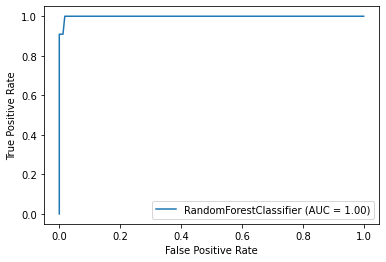

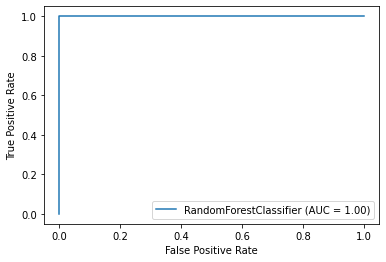

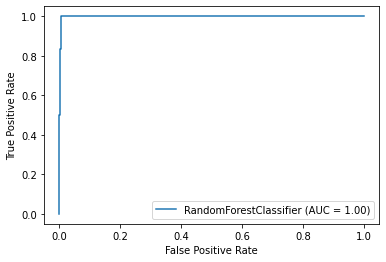

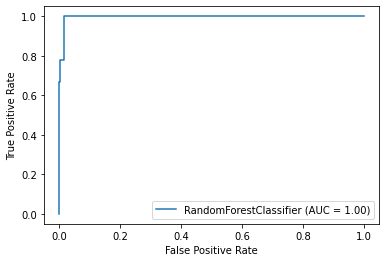

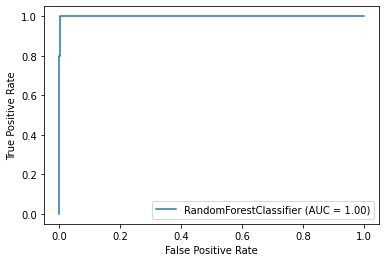

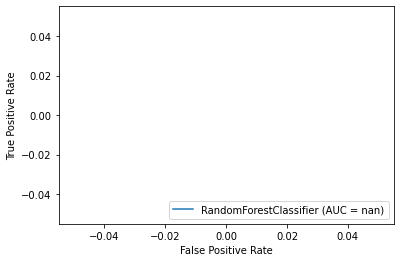

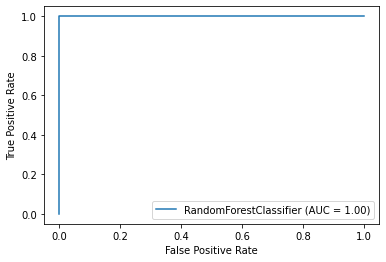

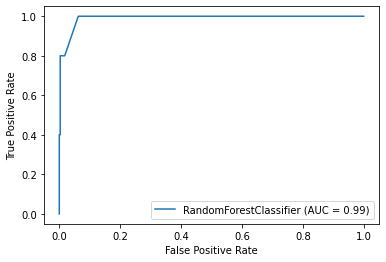

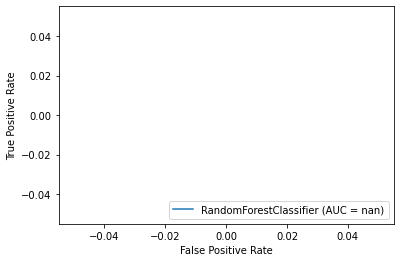

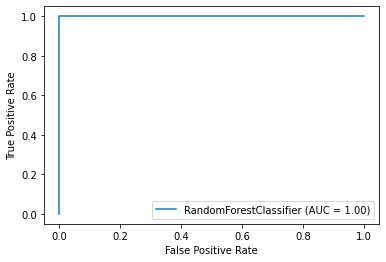

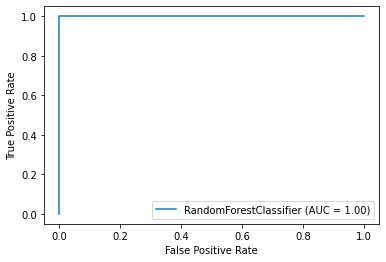

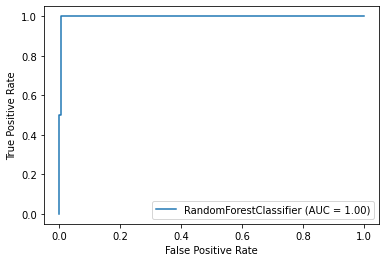

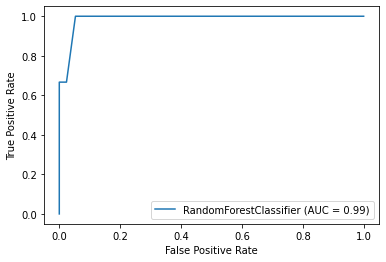

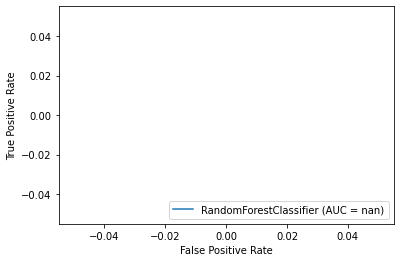

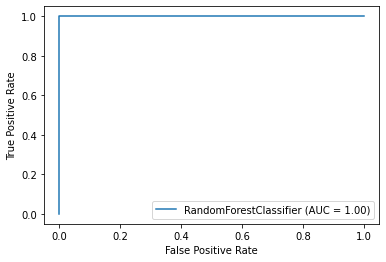

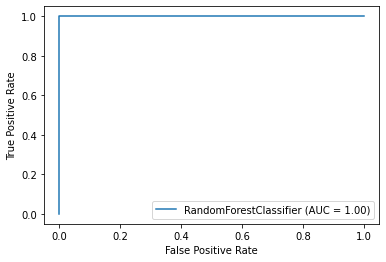

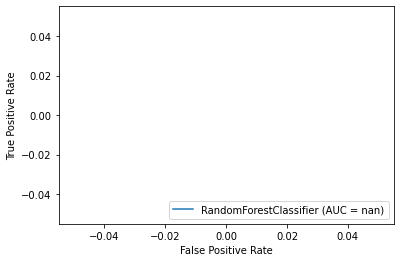

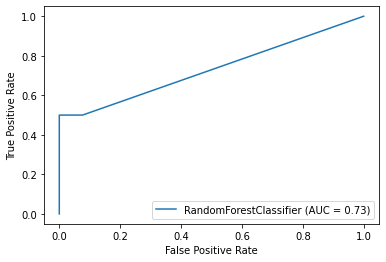

In [21]:
from sklearn.metrics import plot_roc_curve
for model_name in models:
    with open(('models/CLASS_PROSPECTUS_%s_CountVectorizer.rft' % model_name), 'rb') as f:
        model = pickle.load(f)
    with open(('models/VECTOR_PROSPECTUS_%s_CountVectorizer.txt' % model_name), 'rb') as f:
        vector = pickle.load(f)  
    ds = datasets[model_name]['df_validation']
    try:
        plot_roc_curve(model, vector.transform(ds['x']), ds["target"])
    except:
        pass

In [14]:

#IVL: удаляем файлы с прошлого запуска
if os.path.exists('errors'):
    for root, dirs, files in os.walk('errors'):
        for file in files:
            os.remove(f'{root}//{file}')
#IVL: выгружаю только ошибки, пустые таблицы не выгружать
for name in models:
    if len(ds_mistakes_countvectorizer[name])>0: ds_mistakes_countvectorizer[name].to_excel(f'errors//{name}_CountVectorizer.xlsx')
    if len(ds_mistakes_tfidf[name])>0: ds_mistakes_tfidf[name].to_excel(f'errors//{name}_TF-IDF.xlsx')

In [15]:
#IVL: выгружаем примеры для валидации
#IVL: удаляем файлы с прошлого запуска
if os.path.exists('to_validate'):
    for root, dirs, files in os.walk('to_validate'):
        for file in files:
            os.remove(f'{root}//{file}')
#IVL: выгружаю только примеры для валидации, пустые таблицы не выгружать
for name in models:
    if len(ds_to_validate_countvectorizer[name])>0: ds_to_validate_countvectorizer[name].to_excel(f'to_validate//{name}_CountVectorizer.xlsx')
    if len(ds_to_validate_tfidf[name])>0: ds_to_validate_tfidf[name].to_excel(f'to_validate//{name}_TF-IDF.xlsx')